In [271]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as ols
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

In [272]:
#get the data
insurance = pd.read_csv("./insurance.csv")

print("The first 5 rows of the data are", insurance.head())

print("The (Row, Column) is:\n", insurance.shape)

print("Data Type for each column:\n", insurance.dtypes)
print("Number of null values in each column are:\n", insurance.isnull().sum())
print("\n")
print("Numeric Summary:\n", insurance.describe())

The first 5 rows of the data are    age     sex   bmi  children smoker     region  expenses
0   19  female  27.9         0    yes  southwest  16884.92
1   18    male  33.8         1     no  southeast   1725.55
2   28    male  33.0         3     no  southeast   4449.46
3   33    male  22.7         0     no  northwest  21984.47
4   32    male  28.9         0     no  northwest   3866.86
The (Row, Column) is:
 (1338, 7)
Data Type for each column:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object
Number of null values in each column are:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


Numeric Summary:
                age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  1

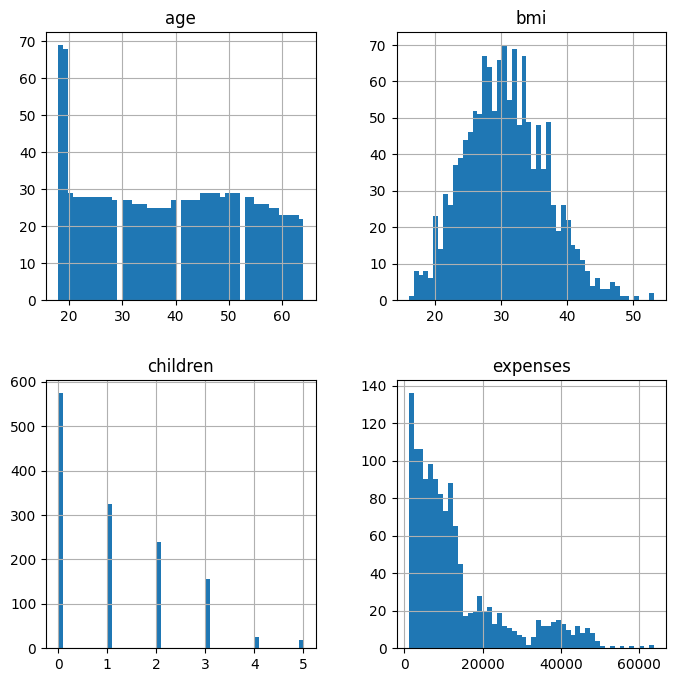

In [273]:
#getting distribution of numeric feature
insurance.hist(bins = 50, figsize=(8,8))
plt.show()

### Assigning Numerical and Categorical Values

In [274]:
def categorical_variable(df):
    return list(df.select_dtypes(include = ['category', 'object']))

def numerical_variable(df):
    return list(df.select_dtypes(exclude = ['category', 'object']))

categorical_features = categorical_variable(insurance)
numeric_features = numerical_variable(insurance)
print(categorical_features)
print(numeric_features)

['sex', 'smoker', 'region']
['age', 'bmi', 'children', 'expenses']


In [275]:
#get the number of unique values in each categorical feature
for i in categorical_features:
    print(insurance[i].value_counts())

#since all these features are categorical

sex
male      676
female    662
Name: count, dtype: int64
smoker
no     1064
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


### Using stratified sample
1. Since the number of samples in data is only 1000
2. We do stratified sampling wrt to Expenses(Target variable)

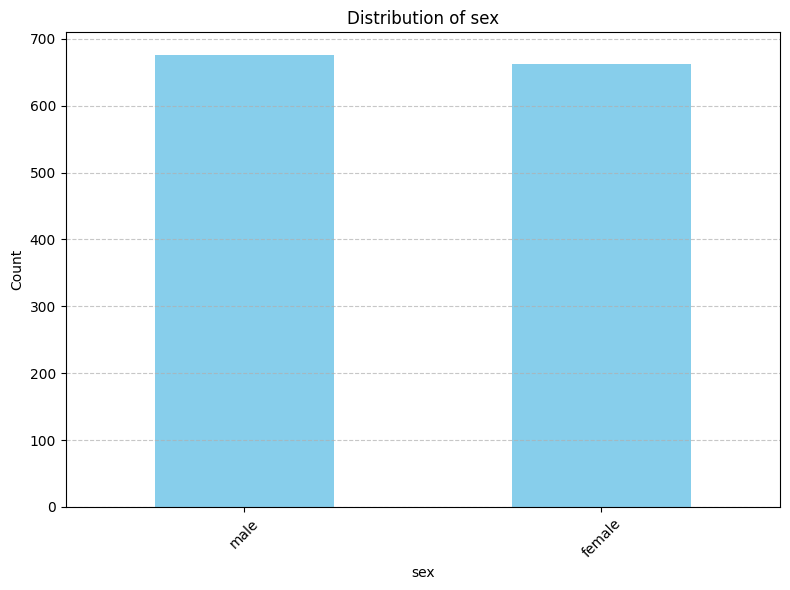

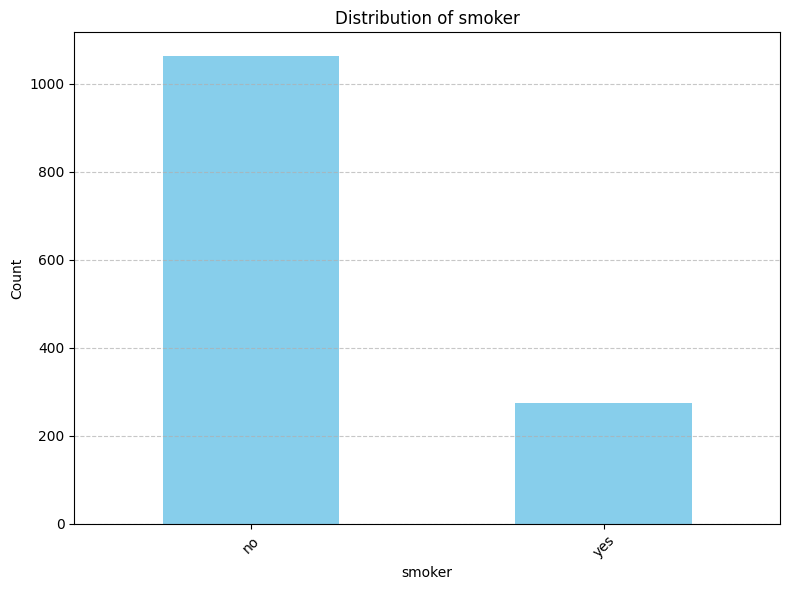

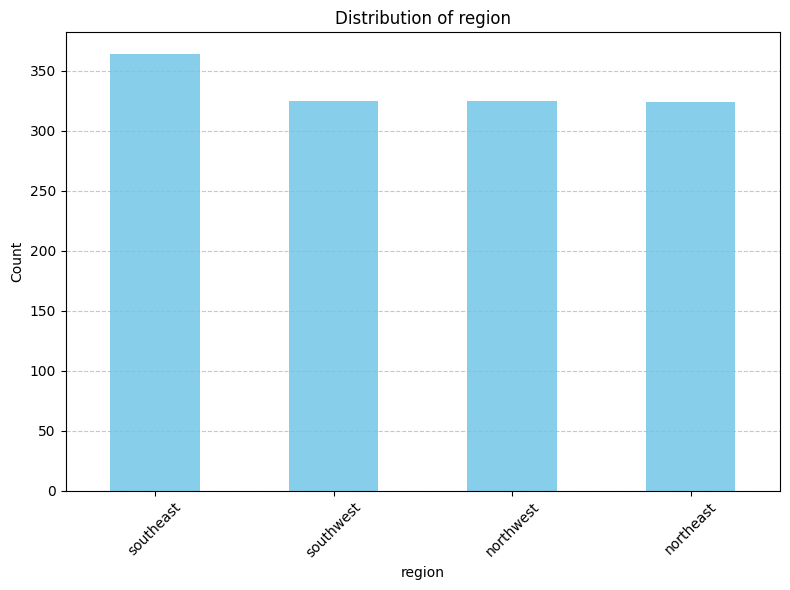

In [276]:
#check the distribution of categorical features
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    insurance[feature].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines
    plt.tight_layout()  # Adjust layout to prevent overlap of labels
    plt.show()

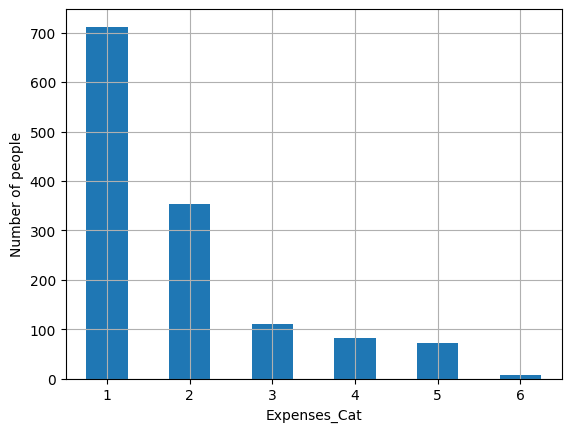

In [277]:
#doing stratified sampling with target variable
insurance['Expenses_Cat'] = pd.cut(insurance["expenses"], 
                            bins = [0,10000,20000,30000,40000,50000,np.inf], 
                            labels=[1,2,3,4,5,6])

insurance["Expenses_Cat"].value_counts().sort_index().plot.bar(rot = 0, grid = True)
plt.xlabel("Expenses_Cat")
plt.ylabel("Number of people")
plt.show()

splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
start_splits = []

for train_index, test_index in splitter.split(insurance, insurance["Expenses_Cat"]):
    strat_train_set_n = insurance.iloc[train_index]
    strat_test_set_n = insurance.iloc[test_index]
    start_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = start_splits[0]
#strat_train_set["Expenses_Cat"].value_counts()

In [278]:
strat_train_set

,age,sex,bmi,children,smoker,region,expenses,Expenses_Cat
893,47,male,38.9,2,yes,southeast,44202.65,5
602,56,female,25.3,0,no,southwest,11070.54,2
477,25,male,35.6,0,no,northwest,2534.39,1
598,43,male,32.6,2,no,southwest,7441.50,1
984,20,male,30.1,5,no,northeast,4915.06,1
...,...,...,...,...,...,...,...,...
762,33,male,27.1,1,yes,southwest,19040.88,2
1282,18,female,21.7,0,yes,northeast,14283.46,2
296,19,male,27.7,0,yes,southwest,16297.85,2
979,36,female,29.9,0,no,southeast,4889.04,1


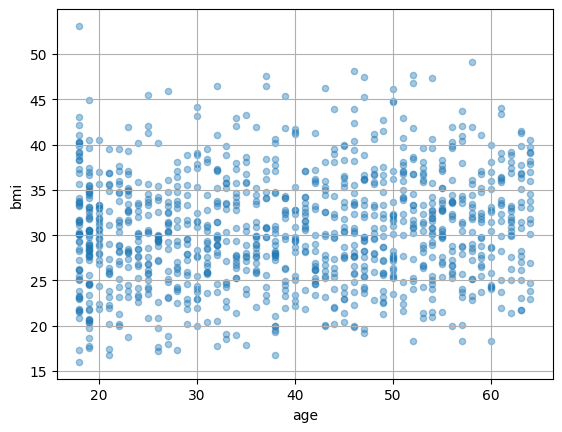

<1070x8 sparse matrix of type '<class 'numpy.float64'>'
	with 3210 stored elements in Compressed Sparse Row format>

In [279]:
#looking for correlation

#making a copy
insurance = strat_train_set.copy()
insurance.plot(kind = "scatter", x = "age", y = "bmi", grid = True, alpha = 0.4)
plt.show()

ohe = OneHotEncoder()
insurance_categorical = insurance[categorical_features]
insurance_categorical_one_hot = ohe.fit_transform(insurance_categorical) #sparse matrix for oneHotEncoding
insurance_categorical_one_hot

In [280]:
#convert sparse matrix to DataFrame
encoded_df = pd.DataFrame(insurance_categorical_one_hot.toarray(),columns=ohe.get_feature_names_out(categorical_features)).astype("int64")

insurance.reset_index(drop=True, inplace=True)
encoded_df.reset_index(drop=True, inplace=True)

#Concatenate with original DataFrame
insurance_encoded = pd.concat([insurance.drop(columns=categorical_features), encoded_df], axis = 1)
insurance_encoded

,age,bmi,children,expenses,Expenses_Cat,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,47,38.9,2,44202.65,5,0,1,0,1,0,0,1,0
1,56,25.3,0,11070.54,2,1,0,1,0,0,0,0,1
2,25,35.6,0,2534.39,1,0,1,1,0,0,1,0,0
3,43,32.6,2,7441.50,1,0,1,1,0,0,0,0,1
4,20,30.1,5,4915.06,1,0,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,33,27.1,1,19040.88,2,0,1,0,1,0,0,0,1
1066,18,21.7,0,14283.46,2,1,0,0,1,1,0,0,0
1067,19,27.7,0,16297.85,2,0,1,0,1,0,0,0,1
1068,36,29.9,0,4889.04,1,1,0,1,0,0,0,1,0


In [281]:
# Now let's do some feature scaling
# I am going to do min-max scaling
min_max_scaler = MinMaxScaler()

# Scale the features and replace the column values with the scaled values
insurance_encoded = pd.DataFrame(min_max_scaler.fit_transform(insurance_encoded), columns=insurance_encoded.columns)

insurance = insurance_encoded
insurance

,age,bmi,children,expenses,Expenses_Cat,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.630435,0.617251,0.4,0.687658,0.8,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.826087,0.250674,0.0,0.158801,0.2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.152174,0.528302,0.0,0.022547,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.543478,0.447439,0.4,0.100874,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.043478,0.380054,1.0,0.060547,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065,0.326087,0.299191,0.2,0.286024,0.2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1066,0.000000,0.153639,0.0,0.210086,0.2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1067,0.021739,0.315364,0.0,0.242240,0.2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1068,0.391304,0.374663,0.0,0.060132,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [282]:
print(insurance.columns)
X_train = insurance.drop(['expenses', 'Expenses_Cat'], axis = 1)
y_train = insurance['expenses']


Index(['age', 'bmi', 'children', 'expenses', 'Expenses_Cat', 'sex_female',
       'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')


Features with VIF > 10 (indicating multicollinearity issues):
             Feature  VIF
3         sex_female  inf
4           sex_male  inf
5          smoker_no  inf
6         smoker_yes  inf
7   region_northeast  inf
8   region_northwest  inf
9   region_southeast  inf
10  region_southwest  inf


C:\Users\vivek\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


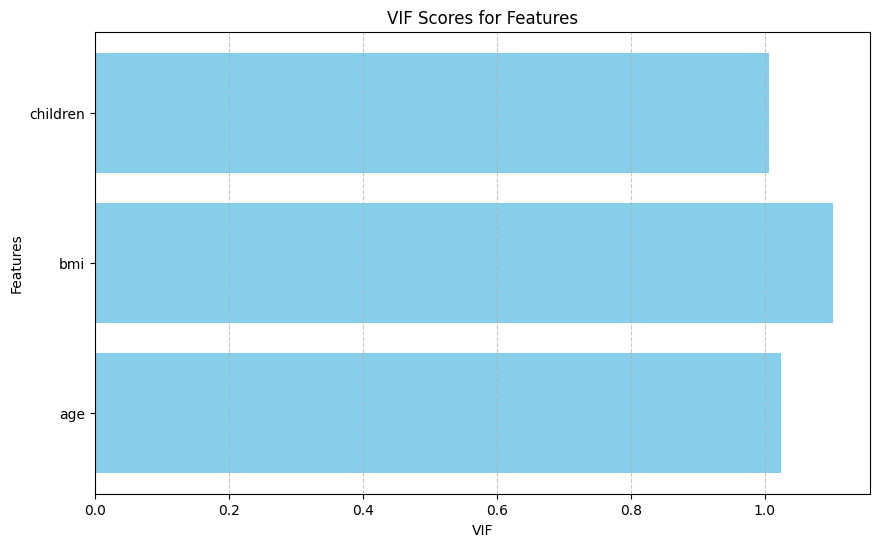

In [283]:
#check for multicollinearity using VIF
#for each feature calculate VIF
#if VIF > 5 multicollinearity present

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X_train.columns))]

# Check for multicollinearity
high_vif_features = vif_data[vif_data["VIF"] > 10]

print("Features with VIF > 10 (indicating multicollinearity issues):")
print(high_vif_features)

# Plot VIF values
plt.figure(figsize=(10, 6))
plt.barh(vif_data["Feature"], vif_data["VIF"], color='skyblue')
plt.xlabel('VIF')
plt.ylabel('Features')
plt.title('VIF Scores for Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


In [284]:
X_train.columns

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

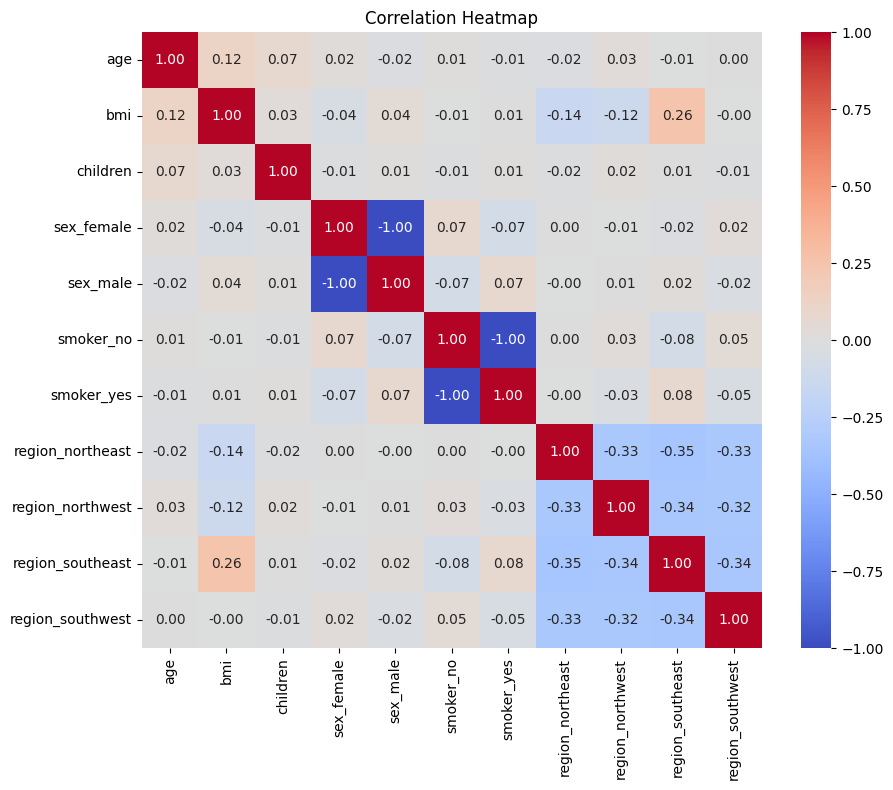

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
age,1.000000,0.123455,0.073923,0.019482,-0.019482,0.013161,-0.013161,-0.023058,0.026082,-0.006915,0.004252
bmi,0.123455,1.000000,0.028560,-0.043697,0.043697,-0.006178,0.006178,-0.141694,-0.120908,0.257463,-0.001849
children,0.073923,0.028560,1.000000,-0.010190,0.010190,-0.012888,0.012888,-0.015362,0.018118,0.006285,-0.009135
sex_female,0.019482,-0.043697,-0.010190,1.000000,-1.000000,0.070441,-0.070441,0.004230,-0.006844,-0.020454,0.023668
sex_male,-0.019482,0.043697,0.010190,-1.000000,1.000000,-0.070441,0.070441,-0.004230,0.006844,0.020454,-0.023668
smoker_no,0.013161,-0.006178,-0.012888,0.070441,-0.070441,1.000000,-1.000000,0.002741,0.030145,-0.077084,0.046545
smoker_yes,-0.013161,0.006178,0.012888,-0.070441,0.070441,-1.000000,1.000000,-0.002741,-0.030145,0.077084,-0.046545
region_northeast,-0.023058,-0.141694,-0.015362,0.004230,-0.004230,0.002741,-0.002741,1.000000,-0.325064,-0.345711,-0.325064
region_northwest,0.026082,-0.120908,0.018118,-0.006844,0.006844,0.030145,-0.030145,-0.325064,1.000000,-0.341375,-0.320988
region_southeast,-0.006915,0.257463,0.006285,-0.020454,0.020454,-0.077084,0.077084,-0.345711,-0.341375,1.000000,-0.341375


In [285]:
import seaborn as sns

# Select the columns of interest for correlation
columns_of_interest = ['age', 'bmi', 'children', 'sex_female', 'sex_male', 
                       'smoker_no', 'smoker_yes', 'region_northeast', 
                       'region_northwest', 'region_southeast', 'region_southwest']

# Calculate the correlation matrix
corr = X_train[columns_of_interest].corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
corr


In [286]:
# Prepare the test set

# Apply one-hot encoding to the categorical features in the test set
strat_test_set_encoded = pd.DataFrame(ohe.transform(strat_test_set[categorical_features]).toarray(), columns=ohe.get_feature_names_out(categorical_features))
strat_test_set_encoded.reset_index(drop=True, inplace=True)
strat_test_set.reset_index(drop = True, inplace=True)
strat_test_set_encoded = pd.concat([strat_test_set.drop(columns=categorical_features), strat_test_set_encoded], axis=1)
strat_test_set_encoded

#now applying feature scalling
min_max_scaler_test = MinMaxScaler()

# Scale the features and replace the column values with the scaled values
strat_test_set_encoded = pd.DataFrame(min_max_scaler.fit_transform(strat_test_set_encoded), columns = strat_test_set_encoded.columns)

strat_test_set = strat_test_set_encoded


X_test = strat_test_set.drop(['expenses', 'Expenses_Cat'], axis=1)
y_test = strat_test_set['expenses'] 

In [287]:
# 3. Train Model
model = LinearRegression()
model.fit(X_train, y_train)

# 4. Make Predictions
y_pred = model.predict(X_test)

# 5. Evaluate Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)
X_train

Mean Squared Error (MSE): 0.01360477782737706
Root Mean Squared Error (RMSE): 0.11663952086397243
R-squared (R2) Score: 0.7201656680342529


,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.630435,0.617251,0.4,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.826087,0.250674,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.152174,0.528302,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.543478,0.447439,0.4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.043478,0.380054,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
1065,0.326087,0.299191,0.2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1066,0.000000,0.153639,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1067,0.021739,0.315364,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1068,0.391304,0.374663,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [288]:
#model with age and bmi (multiplied)
# Create a new feature by multiplying 'age' and 'bmi'
X_train['age_times_bmi'] = X_train['age'] * X_train['bmi']
X_test['age_times_bmi'] = X_test['age'] * X_test['bmi']

# Print the modified X_train and X_test


# 3. Train Model
model2 = LinearRegression()
model2.fit(X_train, y_train)

# 4. Make Predictions
y_pred = model2.predict(X_test)

# 5. Evaluate Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)



Mean Squared Error (MSE): 0.01354382026322107
Root Mean Squared Error (RMSE): 0.1163779199986882
R-squared (R2) Score: 0.7214194936725904


In [290]:
# Create a new feature with heavy emphasis on smoker status
X_train['smoker_emphasis'] = X_train['smoker_yes'] * 2 + X_train['smoker_no']
X_test['smoker_emphasis'] = X_test['smoker_yes'] * 2 + X_test['smoker_no']

# 3. Train Model
model3 = LinearRegression()
model3.fit(X_train, y_train)

# 4. Make Predictions
y_pred = model3.predict(X_test)

# 5. Evaluate Model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
# Print evaluation metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2) Score:", r2)



Mean Squared Error (MSE): 0.013594938506363815
Root Mean Squared Error (RMSE): 0.11659733490249172
R-squared (R2) Score: 0.7203680513335374
